In [ ]:
# Gerekli kütüphanelerin kurulumu ve içe aktarılması
!pip install kagglehub scikit-learn tensorflow

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub
import os
import math

# Veri setini indirme
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
DATASET_ROOT = str(path)
print("Veri seti şu konuma indirildi:", DATASET_ROOT)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Veri seti şu konuma indirildi: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
# Parametreler
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 128 # Stabilite için 32 idealdir
EPOCHS = 10     # Transfer learning için 10 epoch genellikle yeterlidir

# Veri Yolları
TRAIN_DIR = os.path.join(DATASET_ROOT, 'Training')
TEST_DIR = os.path.join(DATASET_ROOT, 'Testing')

# Veri Artırma ve Normalleştirme (Öğrenmeyi iyileştirmek için)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Veri Yükleyiciler
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

NUM_CLASSES = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Önceden eğitilmiş MobileNetV2 modelini yükleme
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Temel modelin ağırlıklarını donduruyoruz
base_model.trainable = False

# Yeni model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/tmp/ipython-input-3325487263.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
STEPS_PER_EPOCH = math.ceil(train_generator.samples / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(test_generator.samples / BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=VALIDATION_STEPS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5790 - loss: 1.2195 - val_accuracy: 0.7925 - val_loss: 0.5480
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 927ms/step - accuracy: 0.8223 - loss: 0.4736 - val_accuracy: 0.8124 - val_loss: 0.5079
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 922ms/step - accuracy: 0.8505 - loss: 0.3924 - val_accuracy: 0.8207 - val_loss: 0.4883
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 927ms/step - accuracy: 0.8642 - loss: 0.3611 - val_accuracy: 0.8513 - val_loss: 0.4056
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 925ms/step - accuracy: 0.8606 - loss: 0.3613 - val_accuracy: 0.8383 - val_loss: 0.4217
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 923ms/step - accuracy: 0.8766 - loss: 0.3239 - val_accuracy: 0.8558 - val_loss: 0.3817
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 955ms/step - accuracy: 0.8774 - loss: 0.3244 - val_accuracy: 0.8421 - val_loss: 0.4208
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 938ms/step - accuracy: 0.8898 - loss: 0.2998 - val_accura

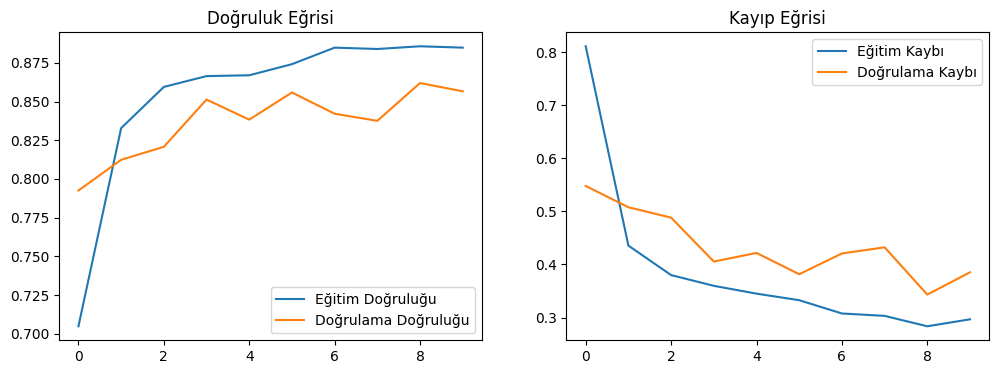

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 608ms/step

--- Karmaşıklık Matrisi ---
[[231  46   1  22]
 [ 15 199  22  70]
 [  1   4 396   4]
 [  1   0   2 297]]

--- Sınıflandırma Raporu (Türkçe Terimler) ---
              precision    recall  f1-score   support

      glioma       0.93      0.77      0.84       300
  meningioma       0.80      0.65      0.72       306
     notumor       0.94      0.98      0.96       405
   pituitary       0.76      0.99      0.86       300

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.84      1311
weighted avg       0.86      0.86      0.85      1311



In [ ]:
# 1. Doğruluk ve Kayıp Grafikleri
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Eğrisi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Eğrisi')
plt.legend()
plt.show()

# 2. Tahminler ve Sınıflandırma Raporu
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print('\n--- Karmaşıklık Matrisi ---')
print(confusion_matrix(y_true, y_pred))

print('\n--- Sınıflandırma Raporu (Türkçe Terimler) ---')
# 'target_names' parametresiyle etiketleri doğrudan rapora ekliyoruz
print(classification_report(y_true, y_pred, target_names=class_labels))

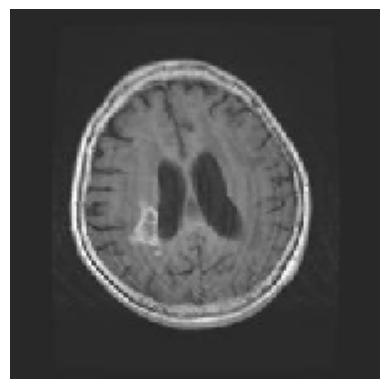

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
--- TAHMİN SONUCU ---
Tespit Edilen Sınıf: GLIOMA
Güven Oranı: %69.03


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def tumor_tahmin_et(img_path):
    # 1. Görüntüyü yükle ve modelin eğitildiği boyuta (150x150) getir
    img = image.load_img(img_path, target_size=(150, 150))

    # 2. Görüntüyü ekranda göster
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # 3. Görüntüyü diziye (array) çevir ve normalleştir (0-1 arası)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Model tek resim değil "batch" bekler
    img_array /= 255.0

    # 4. Model ile tahmin yap
    tahminler = model.predict(img_array)
    sinif_index = np.argmax(tahminler) # En yüksek olasılıklı sınıfın indeksi
    olasilik = tahminler[0][sinif_index] * 100 # Doğruluk yüzdesi

    # 5. Sonucu yazdır
    print(f"--- TAHMİN SONUCU ---")
    print(f"Tespit Edilen Sınıf: {class_labels[sinif_index].upper()}")
    print(f"Güven Oranı: %{olasilik:.2f}")

# KULLANIM:
# Buraya test etmek istediğin resmin yolunu yaz (Örn: 'test_resmi.jpg')
test_path = "/content/G_15_BR_.jpg"
tumor_tahmin_et(test_path)